In [1]:
import numpy as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math

from invisible_cities.reco       import tbl_functions as tbl
from invisible_cities.core.core_functions  import shift_to_bin_centers
from invisible_cities.core .core_functions import weighted_mean_and_std


In [2]:
def get_histograms_from_file(file_input, group_name="DST/Events"):
    with tb.open_file(file_input, mode='r') as h5in:
        full_path = '/' + group_name

        try:
            node = h5in.get_node(full_path)
            if isinstance(node, tb.Group): 
                print(f"'{group_name}' is a Group. Handling as a Group...")
                return {table.name: table.read() for table in node._f_iter_nodes() if isinstance(table, tb.Table)}

            elif isinstance(node, (tb.Table, tb.Array, tb.CArray)):
                print(f"'{group_name}' is a Dataset. Extracting columns...")
                data = node.read()
                if isinstance(data, np.ndarray) and data.dtype.names:
                    return {col: data[col] for col in data.dtype.names}
                else:
                    raise ValueError(f"'{group_name}' is a raw array, but column names are needed for histograms.")

            else:
                raise ValueError(f"'{group_name}' is neither a Group nor a recognized Dataset.")

        except tb.NoSuchNodeError:
            raise ValueError(f"'{group_name}' not found in file '{file_input}'.")


In [3]:
foldername = './'
filename = 'next100_test_data/sophronia_99_208Tl.h5'
input_file = foldername + filename

histograms = get_histograms_from_file(input_file, group_name="DST/Events")
print(histograms.keys())  # can be used for ['E', 'X', 'Y']


'DST/Events' is a Dataset. Extracting columns...
dict_keys(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT', 'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'])


In [4]:
def get_histograms_from_file(file_input, group_name="DST/Events"):
    """Extracts histograms from an HDF5 file, handling different structures."""
    with tb.open_file(file_input, mode='r') as h5in:
        if f'/{group_name}' not in h5in:
            raise ValueError(f"Group '{group_name}' not found in file '{file_input}'.")

        node = h5in.get_node(f'/{group_name}')
        
        if isinstance(node, tb.Table): 
            data = {col: node.col(col)[:] for col in node.colnames}
        elif isinstance(node, tb.Group):  
            data = {ds.name: ds[:] for ds in node._f_list_nodes() if isinstance(ds, tb.Array)}
        else:
            raise TypeError(f"Unsupported node type: {type(node)} in {group_name}")

    return data


In [5]:
foldername = './'
filename = 'next100_test_data/sophronia_99_208Tl.h5'
input_file = foldername + filename

histograms = get_histograms_from_file(input_file, group_name="DST/Events")
print(histograms.keys())  # ['E', 'X', 'Y']

dict_keys(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT', 'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'])


In [6]:
def plot_histograms_from_file(histofile, histonames='all', group_name='DST/Events'):
    """Plots histograms from an HDF5 file in a 3-column grid layout."""
    histograms = get_histograms_from_file(histofile, group_name)

    if histonames == 'all':
        histonames = list(histograms.keys())

    num_histos = len(histonames)
    if num_histos == 0:
        print(f"No histograms found in group '{group_name}'.")
        return

    num_cols = 3
    num_rows = math.ceil(num_histos / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows)) 
    axes = axes.flatten() 

    for i, name in enumerate(histonames):
        if name not in histograms:
            print(f"Warning: Histogram '{name}' not found in '{group_name}'. Skipping.")
            continue

        ax = axes[i]
        ax.hist(histograms[name], bins=50, alpha=0.75, histtype='step', linewidth=1.5, color='black')
        ax.set_xlabel(name)
        ax.set_ylabel('Entries')
        ax.set_title(f'Histogram of {name}')
        
        total_entries = len(histograms[name])
        mean = np.mean(histograms[name])
        rms = np.sqrt(np.mean(np.square(histograms[name] - mean)))
        ax.annotate(f'Entries= {total_entries}\nMean= {mean:.2f}\nRMS= {rms:.2f}',
                    xy=(1, 1), xycoords='axes fraction',
                    xytext=(-5, -5), textcoords='offset points',
                    fontsize=10, ha='right', va='top')
        ax.grid(alpha=.5)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


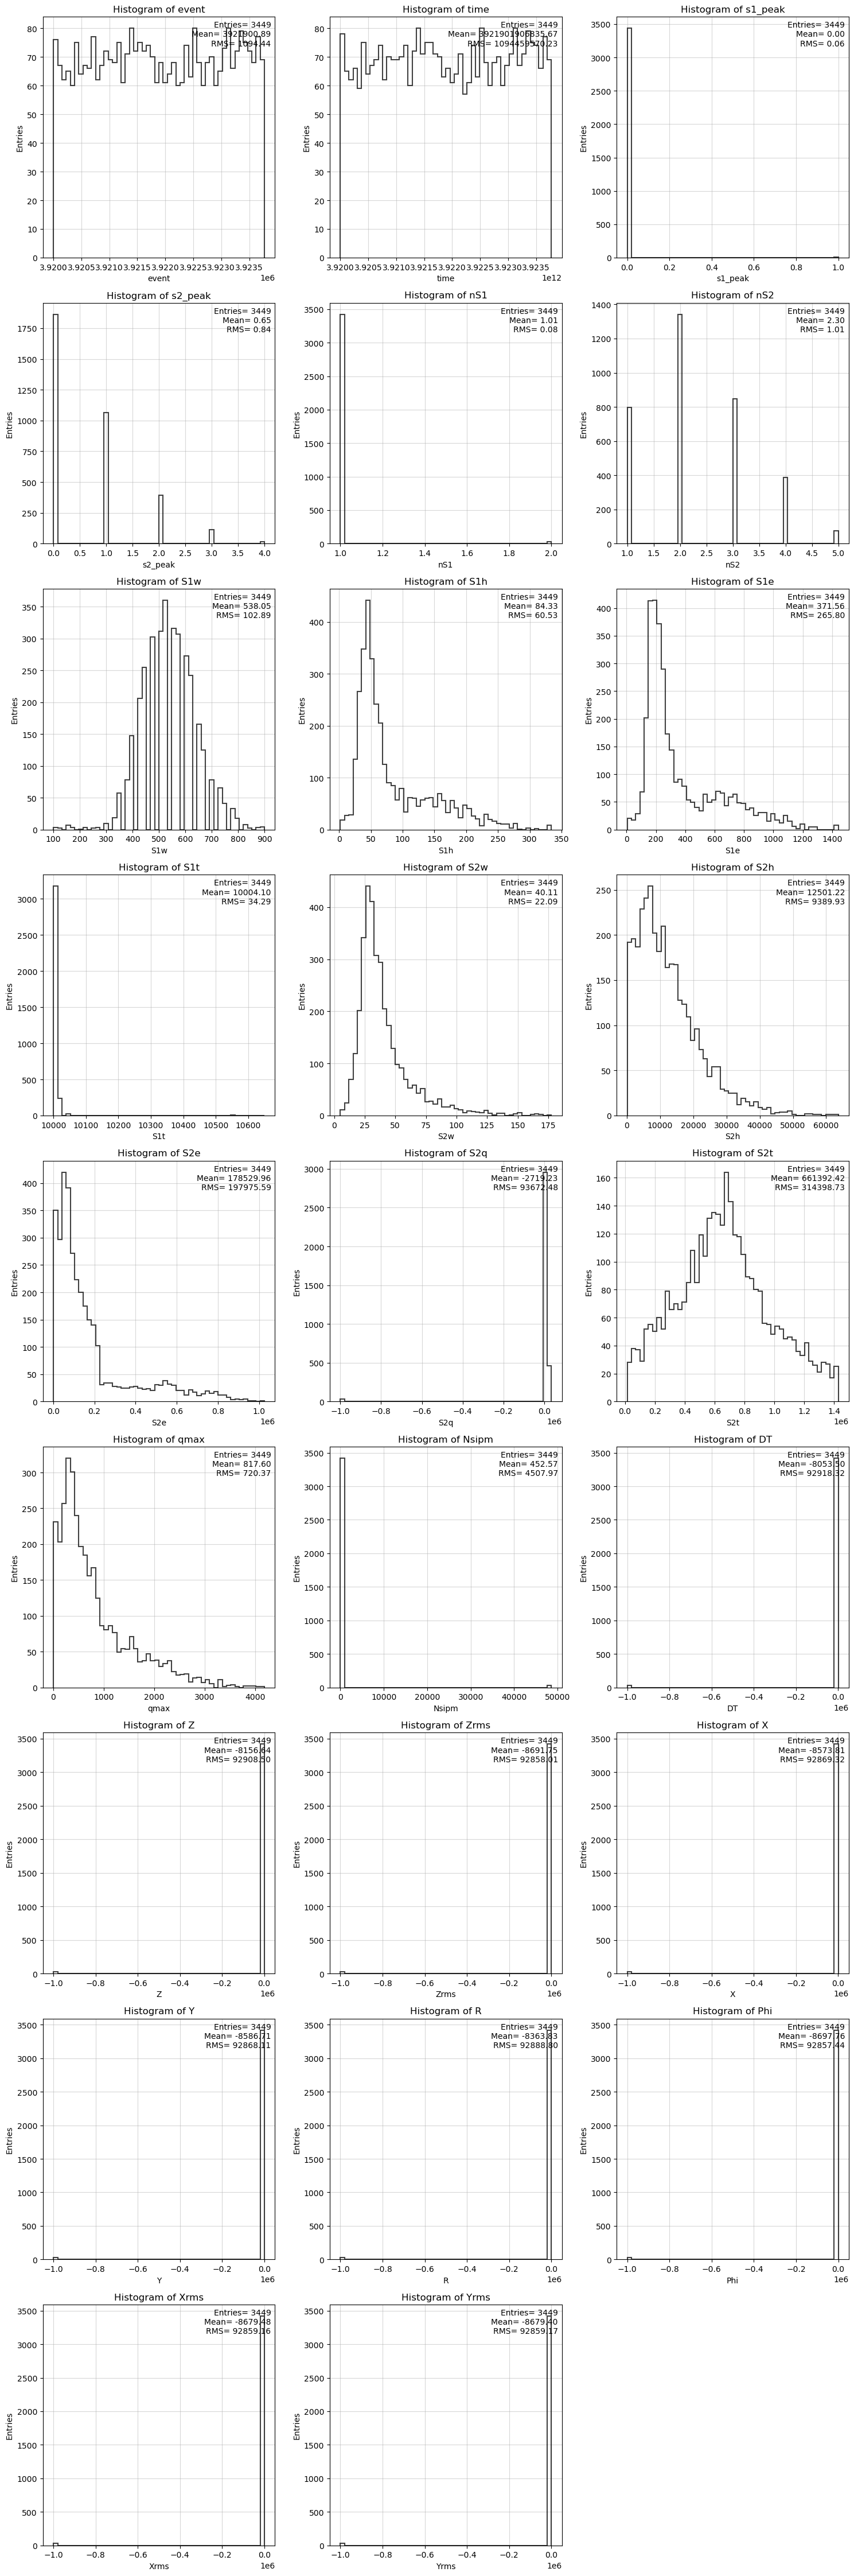

In [7]:
foldername = './'
filename = 'next100_test_data/sophronia_99_208Tl.h5'
input_file = foldername + filename

histograms = get_histograms_from_file(input_file)
#print(histograms.keys())
plot_histograms_from_file(input_file, histonames='all', group_name='DST/Events')

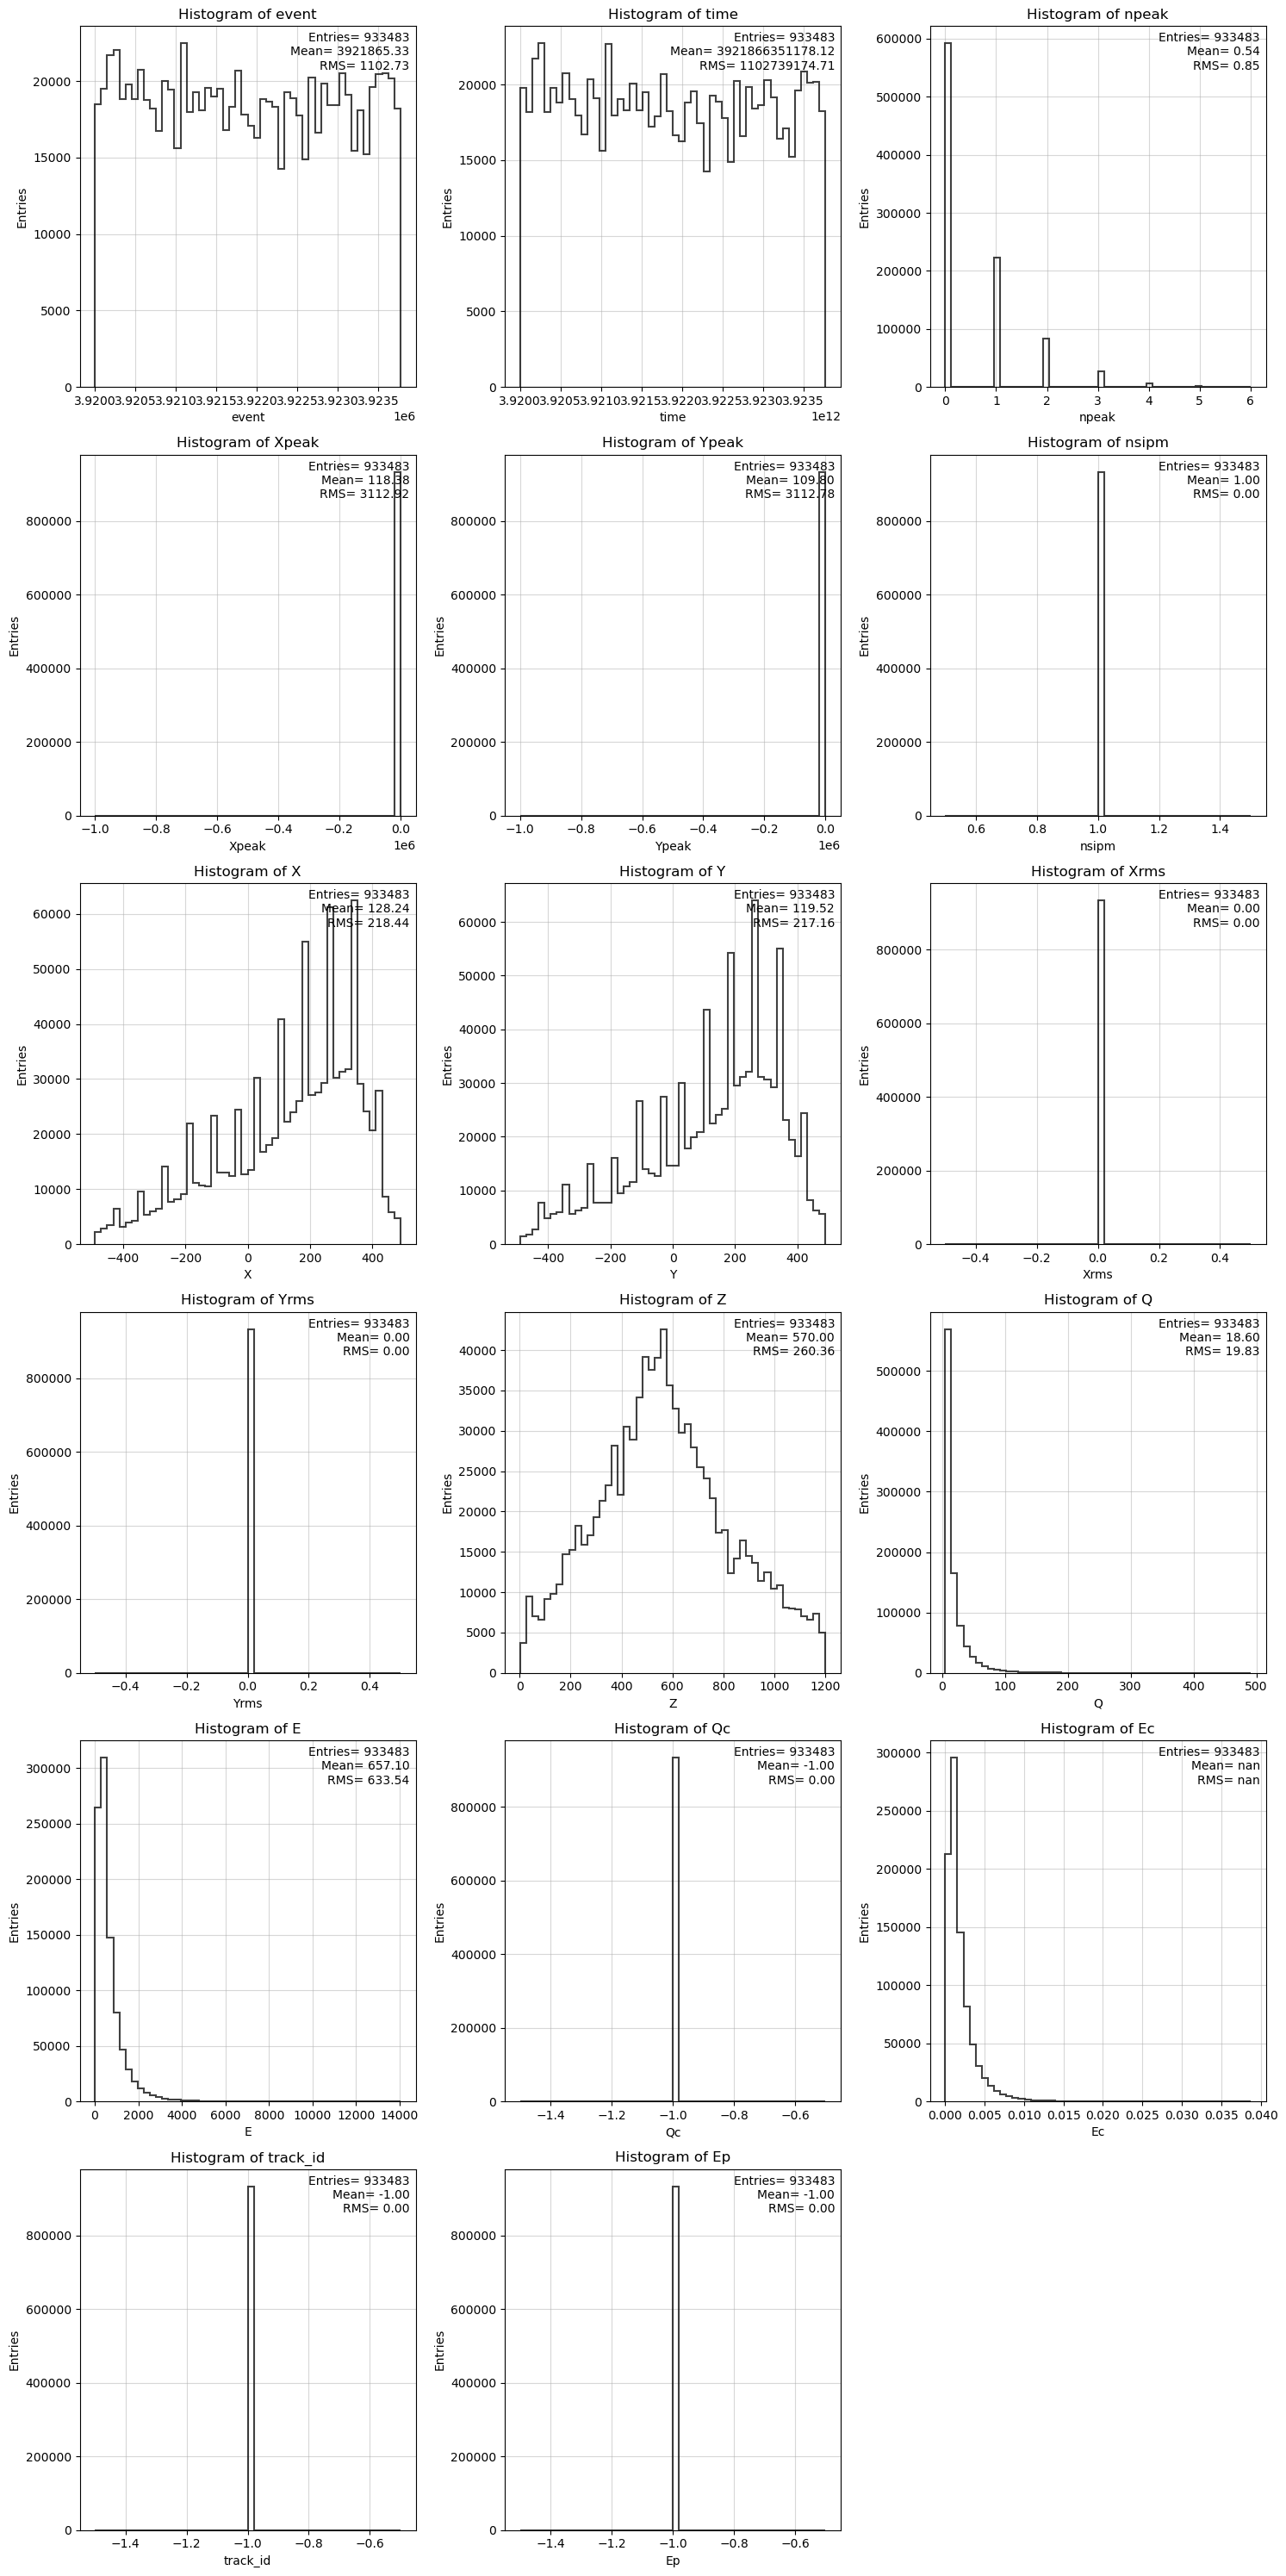

In [8]:
plot_histograms_from_file(input_file, histonames='all', group_name='RECO/Events')
#plot_histograms_from_file(input_file, histonames=['E', 'X', 'Y'], group_name='DST/Events')

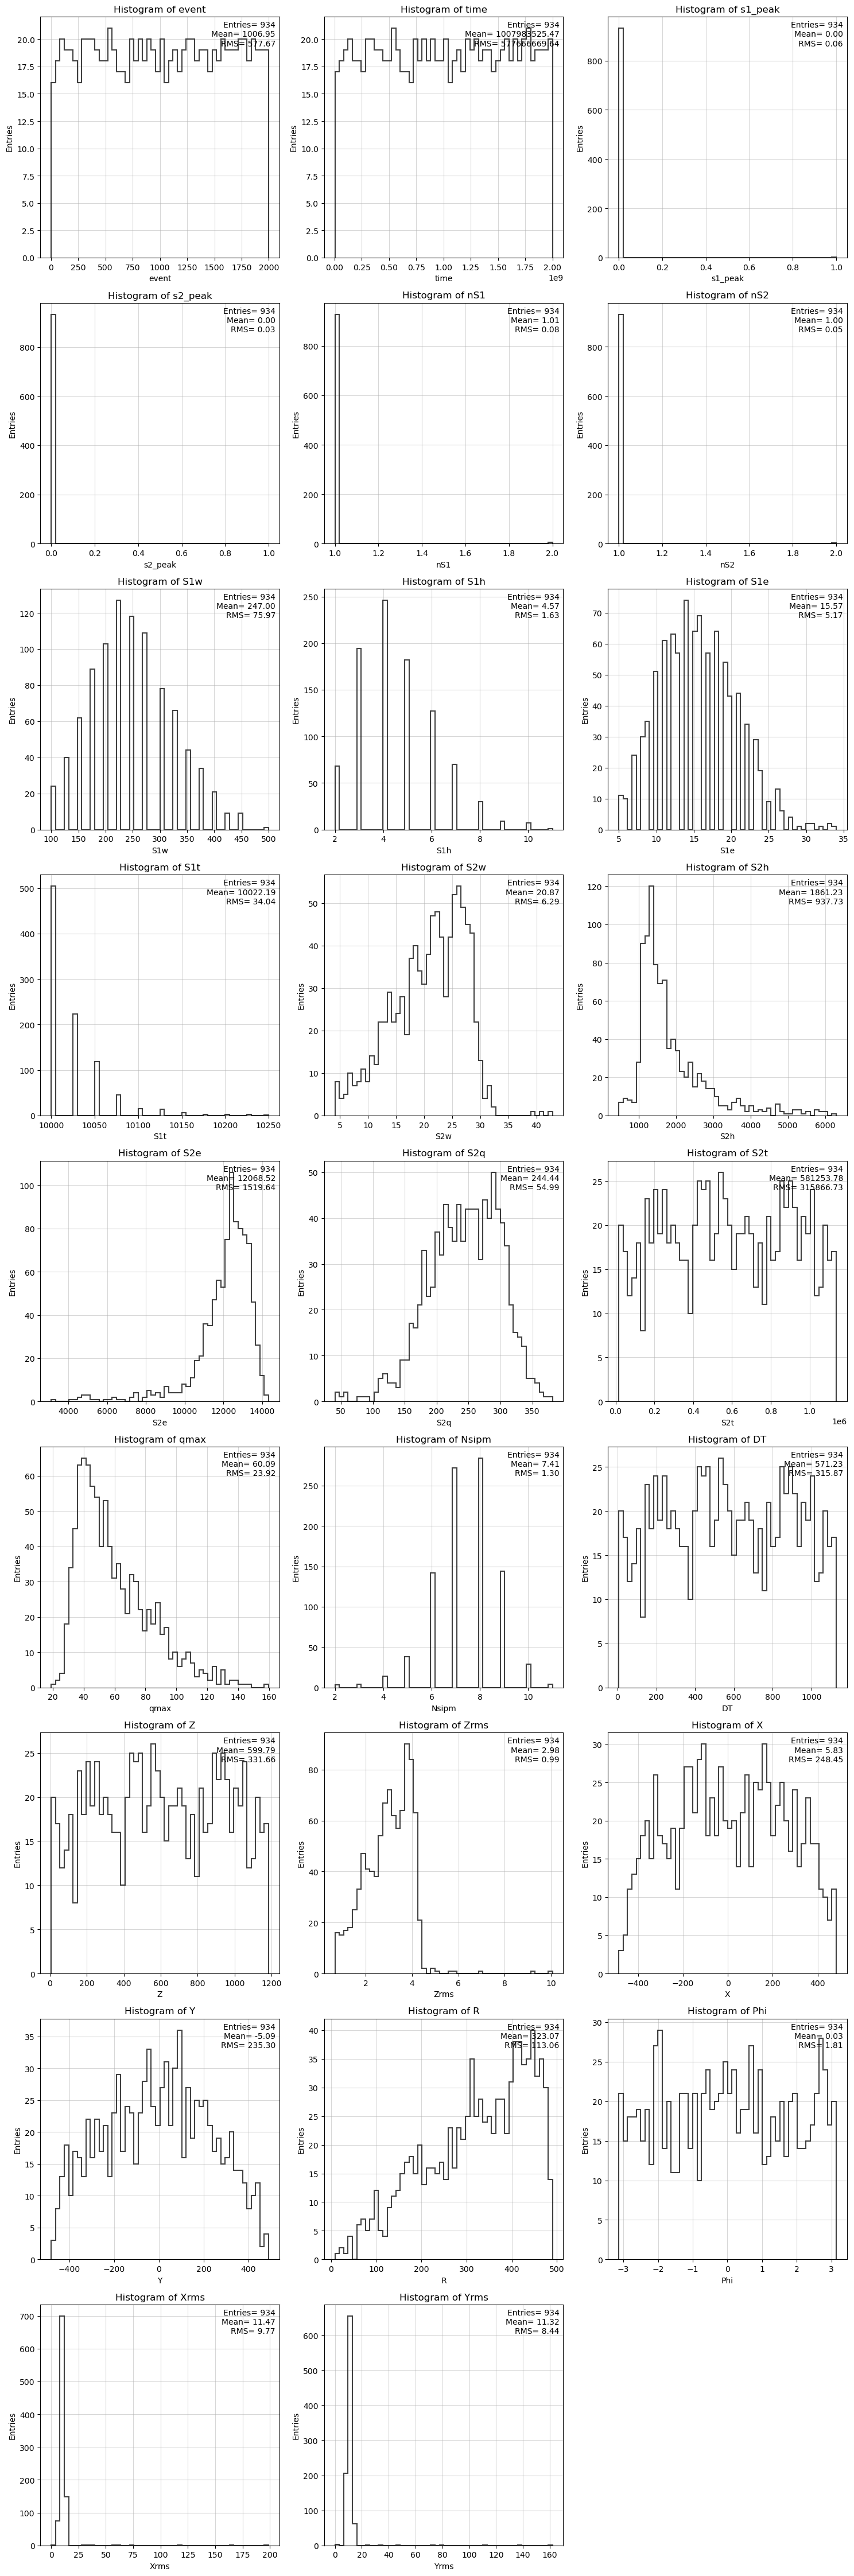

In [9]:
foldername = './'
filename = 'next100_test_data/next100_kr83m_dorothea_1.h5'
input_file = foldername + filename

histograms = get_histograms_from_file(input_file)
#print(histograms.keys())
plot_histograms_from_file(input_file, histonames='all', group_name='DST/Events')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

from olivia.hist_io import get_histograms_from_file
from olivia.histos  import Histogram
from olivia.histos  import HistoManager

from invisible_cities.core.core_functions  import shift_to_bin_centers
from invisible_cities.core .core_functions import weighted_mean_and_std

from olivia.histogram_plot_functions import plot_histograms_from_file
from olivia.histogram_plot_functions import *


foldername = './config/'
filename = 'Th228_pmaps_99_hist.h5'
input_file = foldername + filename

histograms = get_histograms_from_file(input_file)
plot_histograms_from_file(input_file, histonames='all')

Bad pipe message: %s [b'r\xa2\xb5B\xf3E\xa6YGH\xb9\xff\xa3\\\x18\x93\xe2\xc7\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005']
Bad pipe message: %s [b"\xeaf.}<9\x8b0\xde7Y\xbb\xe4W\x18\xdf@'\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\x